# Data for Good: predicting suicidal behavior likelihood among Reddit users using Deep Learning (Part 2)

*Deep Learning and Reinforcement Learning (part of IBM Machine Learning Professional Certificate) - Course Project.*

>*No one is useless in this world who lightens the burdens of another.*  
― **Charles Dickens**

<img src='https://www.discover-norway.no/upload/images/-development/header/desktop/kul_munch/edvard%20munch%20the%20scream%201893_munchmmuseet.jpg'></img>

## Table of contents
1. [Introduction: the project](#project)  
2. [Methodology](#methodology)  
3. [Data Understanding](#data)  
  3.1. [Data Cleaning](#cleaning)  
  3.2. [Exploratory Data Analysis](#eda)  
  3.3. [Data Preparation](#preparation)  
4. [Model Development: Recurrent Neural Network](#model)  
  3.1. [...](#kmeans)  
  3.2. [...](#hac)  
  3.3. [...](#dbscan)  
5. [Results](#results)  
6. [Discussion](#discussion)  
7. [Conclusion](#conclusion)  
  7.1. [Project Summary](#summary)  
  7.2. [Outcome of the Analysis](#outcome)  
  7.3. [Potential Developments](#developments)

## Data Pre-Processing

In [1]:
import keras

---

## 1. Introduction: the project <a name=project></a>

Data for good means using Data Science and Machine Learning tools outside of the for-profit sector, to help Non-profits, NGOs, or any other organization or individual, leverage the power of data for good causes and to improve the life of others.

There are many ways to use the power of Data Science for good: data can be used to solve social issues, environmental problems, enhance community security as well as support people in need. Nowadays, the use of Social Media, forums or news aggregation websites is massively widespread, with people sharing plenty of details about their life. Some people also use internet to share very serious issues, as a cry for help.  
**The scope of this project is using the content created by the users themselves, in an online community, to analyze underlying mental health issues, and try to predict suicidal behavior likelihood among anonymized users.**

The algorithm, if successful, can be used for **targeted suicide intervention:** identify those people at highest risk of self-harm or suicide, so that actions can be undertaken to provide help and support in a timely-fashioned and sustained manner.

## 2. Methodology <a name=methodology></a>

Based on the project requirement, I'll follow a **predictive analytic approach aimed to correctly classify user posts into the correct category.**

To deliver reliable results, I'll follow the <a href='https://en.wikipedia.org/wiki/Cross-industry_standard_process_for_data_mining'>**Cross-Industry Standard Process for Data Mining (CRISP-DM)**</a>, which consists of the following steps:  
1. **Business Understanding** (see the Introduction section)  
2. **Data Understanding**: data cleaning and exploratory data analysis.  
3. **Data Preparation**: transform data into a usable dataset for modeling.  
4. **Modeling**: I 'll build 3 Deep Learning models, using the Recurrent Neural Network class:  
   4.1. Simple Recurrent Neural Network, with an additional Dense layer to output the predicted classification.  
   4.2. Long-Short Term Memory (LSTM) Networks  
   4.3. Gated Recurrent Unit (GRU) Networks  
5. **Evaluation**: model performances will be evaluated using the following metrics: loss function, Jaccard Index (Accuracy Score), Confusion Matrix, Classification Report, Precision/Recall, F1-Score (curves like ROC or precision-recall, but in am not sure I can use curves for multi-class classification) as well as visually inspecting the model results.

## 3. Data Understanding <a name=data></a>

In [1]:
import pandas as pd
pd.set_option('display.max_colwidth', 50)
import random
from random import randrange, seed

In [2]:
data = pd.read_csv(r'500_Reddit_users_posts_labels.csv')
data.head()

,User,Post,Label
0,user-0,"['Its not a viable option, and youll be leavin...",Supportive
1,user-1,['It can be hard to appreciate the notion that...,Ideation
2,user-2,"['Hi, so last night i was sitting on the ledge...",Behavior
3,user-3,['I tried to kill my self once and failed badl...,Attempt
4,user-4,['Hi NEM3030. What sorts of things do you enjo...,Ideation


In [3]:
data.tail()

,User,Post,Label
495,user-495,"['Its not the end, it just feels that way. Or ...",Supportive
496,user-496,"['It was a skype call, but she ended it and Ve...",Indicator
497,user-497,['That sounds really weird.Maybe you were Dist...,Supportive
498,user-498,['Dont know there as dumb as it sounds I feel ...,Attempt
499,user-499,"['&gt;It gets better, trust me.Ive spent long ...",Behavior


In [4]:
print('Number of tuples in the dataset : {}. Number of attributes in the dataset: {}.'.format(data.shape[0], data.shape[1]))

Number of tuples in the dataset : 500. Number of attributes in the dataset: 3.


In [5]:
data.columns

Index(['User', 'Post', 'Label'], dtype='object')

In [6]:
data.dtypes

User     object
Post     object
Label    object
dtype: object

In [7]:
print('Number of unique values in column "{}": {}'.format(data.columns[0], data['User'].nunique()))
print('Number of unique values in column "{}": {}'.format(data.columns[1], data['Post'].nunique()))
print('Number of unique values in column "{}": {}'.format(data.columns[2], data['Label'].nunique()))

Number of unique values in column "User": 500
Number of unique values in column "Post": 500
Number of unique values in column "Label": 5


In [8]:
print('Unique values in column "Label":',data['Label'].unique())

Unique values in column "Label": ['Supportive' 'Ideation' 'Behavior' 'Attempt' 'Indicator']


Let's print the posts from one random user from each one of the labels.

In [9]:
print('Posts from a user labelled as "Supportive":')
print('')
random.seed(2)
print(data[data.Label == 'Supportive']['User'].iloc[randrange(data[data.Label == 'Supportive'].shape[0])]+':')
random.seed(2)
print(data[data.Label == 'Supportive']['Post'].iloc[randrange(data[data.Label == 'Supportive'].shape[0])])

Posts from a user labelled as "Supportive":

user-29:
['Then maybe returningt there might be the first step. You should be w/ the family of your choice, not w/ people who clearly dont want the best for you. You should take care of yourself for a while and while doing that maybe also put some distance between you and that girl - it might help you to put things into perspective. Stay strong!', 'No matter whether you believe in fate or God or anything: that misfiring gun was a SIGN and Im really thankful for it. I hope you can use this extreme experience to your advantage!', 'Scumbag brain... Sees something beautiful and uplifting: yanks the tear ducts wiiide open...', 'Please dont feel guilty. You have a disease and it is so strong that even your partners love cant seem to stop it. Its not your fault and its not an unusual thing to happen. Maybe its really for the best if you outsource the job of taking care of you. That could take the feeling of guilt off your shoulders and also relieve

In [10]:
print('Posts from a user labelled as "Ideation":')
print('')
random.seed(7)
print(data[data.Label == 'Ideation']['User'].iloc[randrange(data[data.Label == 'Ideation'].shape[0])]+':')
random.seed(7)
print(data[data.Label == 'Ideation']['Post'].iloc[randrange(data[data.Label == 'Ideation'].shape[0])])

Posts from a user labelled as "Ideation":

user-227:
['possibly!sorry about the empty post. its sort of a hard subject to just jump into.basically, ive been constantly Delusional disorder at my uni for the past couple of months, and it has been extremely detrimental to my mental health. its especially bad when doing anything online when i most feel like im being spied on, making it extremely difficult to reach out for help in any way. i had to stop talking with one of my good friends online because the Delusional disorder was so bad.the whole situation makes me want to dissapear because of how much it makes me feel isolated with no chance that things will get better. ']


In [11]:
print('Posts from a user labelled as "Behavior":')
print('')
random.seed(8)
print(data[data.Label == 'Behavior']['User'].iloc[randrange(data[data.Label == 'Behavior'].shape[0])]+':')
random.seed(8)
print(data[data.Label == 'Behavior']['Post'].iloc[randrange(data[data.Label == 'Behavior'].shape[0])])

Posts from a user labelled as "Behavior":

user-134:
['Thank you so much for this.', 'I dont know what to say. I dont even know how to feel or if my emotions are justified. I know that my dad has a right to be frustrated with me. After I lost my job, the bills started to pill on and now theyre hovering over my head like a storm cloud.But its not the fact that Ive lost my job and have no room to my own thats bothering me right now. Its the hurtful things he said to me this morning.Now Im too Anxiety to sleep, I feel worse about myself than I have in the past few weeks. The last time my father hugged me or showed any visible/palpable affection towards me was when I graduated high school five years ago. I had to graduate for him to tell me he was proud of me and that he loved me.Most of the time its static apathy or blatant resentment. There is no warmth there. Im always on eggshells around him. Which hurts even worse because I used to be a real daddys girl. We used to be close, when I wa

In [12]:
print('Posts from a user labelled as "Attempt":')
print('')
random.seed(9)
print(data[data.Label == 'Attempt']['User'].iloc[randrange(data[data.Label == 'Attempt'].shape[0])]+':')
random.seed(9)
print(data[data.Label == 'Attempt']['Post'].iloc[randrange(data[data.Label == 'Attempt'].shape[0])])

Posts from a user labelled as "Attempt":

user-333:
['I went through this as well.  During my depression, it was easy to be sad and use the sadness as an excuse to justify my actions.  Although I was in pain, in a way, it was comfortable.  I try to keep myself physically busy to hinder the temptation of being sad and cynical.  Its pretty hard, I hope you go through it well.', 'I hear you.  I woke up in ER after half bottle of vodka and few vicodins.  I laugh about it now.  Failing to kill myself help me abandon all my responsibilities and try a care free life for once.  It was great, but eventually, I realized a person cannot live without tasks or work.', 'Nowadays, it is easier to make money on YouTube.  It is not easy, but easier.  Be consistent and be productive.  It is playing a game, but when it becomes work, it is hard.  Put up few videos every months and eventually, you will get there.', 'I feel the same way.  No desire or passion towards anything.  While Im walking through the 

In [13]:
print('Posts from a user labelled as "Indicator":')
print('')
random.seed(15)
print(data[data.Label == 'Indicator']['User'].iloc[randrange(data[data.Label == 'Indicator'].shape[0])]+':')
random.seed(15)
print(data[data.Label == 'Indicator']['Post'].iloc[randrange(data[data.Label == 'Indicator'].shape[0])])

Posts from a user labelled as "Indicator":

user-171:
['Ironically social work. I never really had fun with his friends, he was just emotionally stable but really really really lazy. Our friends were mostly people from his program in university, so I never really had too much to talk to them about. I feel so guilty that I dont feel sad that hes gone. I just feel so lonely all the time now. ', 'Still got another two years to go haha. ', 'Yeah I think we can do it, we totally got this! But it is *hard* to be normal. I spend so much time and energy trying to make it appear that my life is groovy and drama free that everything I do these days feels like a lie. How does temporary academic leave work? Thanks so much for the reply.']


Dataset source: <a href='https://www.kaggle.com/datasets/thedevastator/c-ssrs-labeled-suicidality-in-500-anonymized-red'>www.kaggle.com</a>.  

The dataset includes posts from 500 redditors that have discussed topics about suicide and mental health illness like depression. The posts have been classified into 5 categories, following a modified version of the guidelines outlined in the Columbia Suicide Severity Rating Scale (C-SSRS).

The dataset contains 3 columns for 500 observations, where each column contains text-type data. Columns are as follows:
- **User:** a string of characters representing an anonymized Reddit user ID.
- **Post:** the text from the user's posts (without no personal information revealed).
- **Label:** the class the users has been assigned to, based on their posts' content. Classes are as follows:
   - Supportive: users show empathy and support people's feeling, discouraging them from suicidal ideas.
   - Ideation: users are going through rough paths, they wish to die or disappear, and they have little hope things get better
   - Behavior: users show suicidal behaviors.
   - Attempt: users have attempted suicide.
   - Indicator: users show some signs of distress like depression, sadness, or other mental health issues.

### 3.1. Data Cleaning <a name=cleaning></a>

In [14]:
# Looking for duplicates
print('Number of duplicate observation in the dataset:',data.duplicated().sum())

Number of duplicate observation in the dataset: 0


In [15]:
# Looking for missing values
for col in data.columns:
    print('Number of missing values in the attribute {}: {}'.format(col, data[col].isnull().sum()))

Number of missing values in the attribute User: 0
Number of missing values in the attribute Post: 0
Number of missing values in the attribute Label: 0


In [16]:
# Visualize post with extra consecutive white spaces before formatting
pd.set_option('display.max_colwidth', None)
data[data['Post'].str.contains('              ')].Post

61    ['Hey man,     You cant be convinced and I cannot change your mind.  Okay.        I am going to tell you not to do this for a completely different reason than you would think.  I mean, consider it.  If you die it is nothing to me, right?  You are just words on a screen (not really - but I hope you understand how I mean this).  Really I have no vested interest in your survival.         However, I am interested in saving you from Pain.  I dont like Pain.  Never been much of a fan.  Theres too much Pain in the world already to inflict it on ourselves physically.        Effexor is NOT the drug you want to OD on.  Trust me.  I am no doctor or scientist but I have read the literature on how it works and have had some firsthand experience.        The first thing you need to understand when making this decision is that you *may* end up in a hospital.  You *may* end up in a great deal of Pain while you lie helpless in a hospital bed waiting to die, but you *may* not even know what is happ

In [17]:
# Data Formatting: 1. delete consecutive white spaces (up to 14 consecutive white spaces)
cws = '              '
while len(cws) > 1:
    data['Post'] = data['Post'].str.replace(cws, cws[:-1])
    cws = cws[:-1]

In [18]:
# Visualize post with extra consecutive white spaces after formatting
data.loc[61]

User                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

In [19]:
#Data Formatting: 2. remove leading and trailing whie spaces
data.Post.str.strip()
pd.set_option('display.max_colwidth', 50)
data.Post

0      ['Its not a viable option, and youll be leavin...
1      ['It can be hard to appreciate the notion that...
2      ['Hi, so last night i was sitting on the ledge...
3      ['I tried to kill my self once and failed badl...
4      ['Hi NEM3030. What sorts of things do you enjo...
                             ...                        
495    ['Its not the end, it just feels that way. Or ...
496    ['It was a skype call, but she ended it and Ve...
497    ['That sounds really weird.Maybe you were Dist...
498    ['Dont know there as dumb as it sounds I feel ...
499    ['&gt;It gets better, trust me.Ive spent long ...
Name: Post, Length: 500, dtype: object

### 3.2. Exploratory Data Analysis <a name=eda></a>

In [20]:
import matplotlib.pyplot as plt

In [21]:
data.describe()

,User,Post,Label
count,500,500,500
unique,500,500,5
top,user-0,"['Its not a viable option, and youll be leavin...",Ideation
freq,1,1,171


Users whose posts have been labelled as "Ideation" are the majority. Let's plot a frequency distribtion plot to see how classes are distributed, and each class percentage over the total.

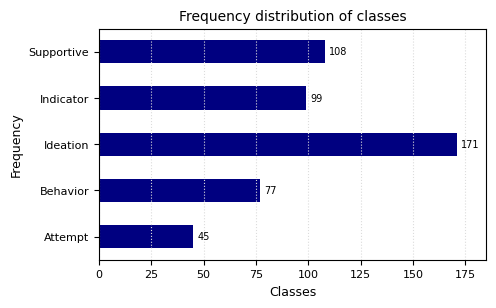

In [22]:
#plt.rcParams['axes.facecolor'] = 'white'
class_freq = data.groupby(['Label']).size()
barchart = class_freq.plot(x=class_freq.index, y=class_freq, kind='barh', figsize=(5,3), color='navy', xlim=(0,185))

for i in barchart.patches:
    barchart.annotate(i.get_width(), # get the frequency of the variable categories
                      xy = (i.get_width()+2, i.get_y() + i.get_height()-0.25), # set the coordinates for each label
                      ha='left', # set the horizontal alignment
                      va='center', # set the vertical alignment
                      fontsize=7) # set the font size

plt.title('Frequency distribution of classes', fontsize=10)
plt.xlabel("Classes", fontsize=9)
plt.ylabel('Frequency', fontsize=9)
plt.yticks(fontsize=8)
plt.xticks(fontsize=8)

plt.grid(True, axis='x', color='gainsboro', ls= ':', linewidth=0.8)
plt.show()

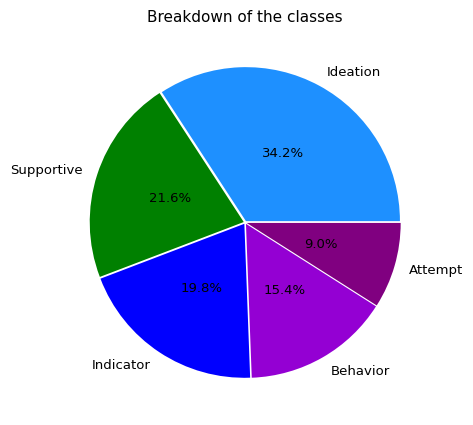

In [23]:
data['Label'].value_counts().plot(kind='pie',
                                  figsize=(5,5), # set axis lengths
                                  autopct='%1.1f%%',
                                  startangle=0, # rotates the start of the pie by ... degree counter-clock wise
                                  shadow=False, #add a shadow
                                  labels=data['Label'].value_counts().index,
                                  pctdistance=0.5, # push out the slice values
                                  colors=['dodgerblue','green','blue','darkviolet','purple'],
                                  fontsize=9.5,
                                  explode=[0.01,0.01,0.01,0.01,0.01])

plt.title('Breakdown of the classes', fontsize=11)
plt.axis('off')
plt.show()

C:\Users\sebas\AppData\Local\Temp\ipykernel_6756\3769143197.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  barchart.set_xticklabels(range(0,180,25), fontsize=8.5)


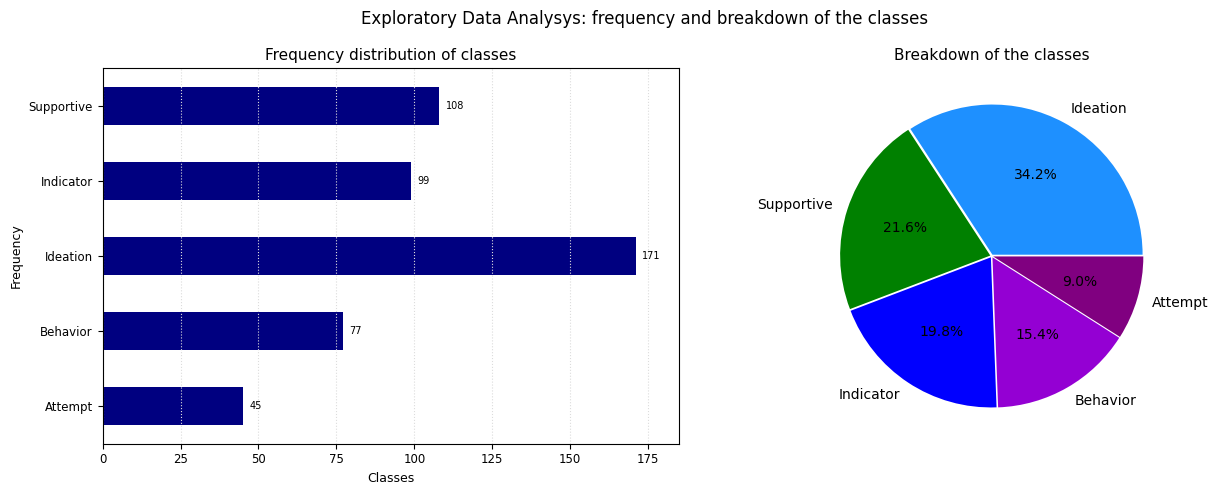

In [24]:
fig = plt.figure(figsize=(13,5))
barchart = fig.add_subplot(1,2,1) 
piechart = fig.add_subplot(1,2,2)


class_freq.plot(x=class_freq.index, y=class_freq, kind='barh', color='navy', xlim=(0,185), ax=barchart)
for i in barchart.patches:
    barchart.annotate(i.get_width(), # get the frequency of the variable categories
                      xy = (i.get_width()+2, i.get_y() + i.get_height()-0.25), # set the coordinates for each label
                      ha='left', # set the horizontal alignment
                      va='center', # set the vertical alignment
                      fontsize=7) # set the font size

barchart.set_title('Frequency distribution of classes', fontsize=11)
barchart.set_xlabel("Classes", fontsize=9)
barchart.set_ylabel('Frequency', fontsize=9)
barchart.set_xticklabels(range(0,180,25), fontsize=8.5)
barchart.set_yticklabels(class_freq.index, fontsize=8.5)
barchart.grid(True, axis='x', color='gainsboro', ls= ':', linewidth=0.8)

data['Label'].value_counts().plot(kind='pie',
                                  #figsize=(3,3), # set axis lengths
                                  autopct='%1.1f%%',
                                  startangle=0, # rotates the start of the pie by ... degree counter-clock wise
                                  shadow=False, #add a shadow
                                  labels=data['Label'].value_counts().index,
                                  pctdistance=0.6, # push out the slice values
                                  colors=['dodgerblue','green','blue','darkviolet','purple'],
                                  fontsize=10,
                                  explode=[0.01,0.01,0.01,0.01,0.01],
                                  ax=piechart)

piechart.set_title('Breakdown of the classes', fontsize=11)
piechart.set_ylabel('')

fig.suptitle('Exploratory Data Analysys: frequency and breakdown of the classes', fontsize=12)
plt.tight_layout(pad=1.08)
plt.show()

NEXT STEPS FOR EDA:
- WORDCLOUDS per each class
- class description

---

In [34]:
import keras

In [35]:
from tensorflow.keras.models import Sequential

sources for data-preprocessing:
- https://towardsdatascience.com/generating-text-with-recurrent-neural-networks-based-on-the-work-of-f-pessoa-1e804d88692d
- https://towardsdatascience.com/recurrent-neural-networks-by-example-in-python-ffd204f99470
- https://medium0.com/@saad.arshad102/sentiment-analysis-text-classification-using-rnn-bi-lstm-recurrent-neural-network-81086dda8472

STEPS:
1. Remove punctuation (debatable) -> probably the right thing to do for text classification
2. Lower case all words (debatable) -> probably the right thing to do for text classification
2. Split strings into lists of individual words -> Tokenize the posts
4. Remove stop words (debatable)
3. Convert the individual words into integers

---

data source: https://www.kaggle.com/datasets/thedevastator/c-ssrs-labeled-suicidality-in-500-anonymized-red
https://zenodo.org/record/2667859#.Y9aqCXZBw2z

In [ ]:
import pandas as pd
data = pd.read_csv(r'500_anonymized_Reddit_users_posts_labels.csv')

In [ ]:
data

In [ ]:
data.loc[26:27]

In [ ]:
data.loc[76:78]

In [ ]:
data.shape

In [ ]:
data_1 = pd.read_csv(r'500_Reddit_users_posts_labels.csv')

In [ ]:
data_1

In [ ]:
data_1.loc[26:27]

In [ ]:
data_1.loc[76:78]

In [ ]:
data_1.loc[497:]

In [ ]:
data_1.shape